In [75]:
%run "rossmann_01_preprocessing.ipynb"

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 25 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int32         
 1   day_of_week                   1017209 non-null  int8          
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int32         
 5   open                          1017209 non-null  int8          
 6   promo                         1017209 non-null  int8          
 7   state_holiday                 1017209 non-null  category      
 8   school_holiday                1017209 non-null  int8          
 9   store_type                    1017209 non-null  category      
 10  assortment                    1017209 non-null  category      
 11

In [76]:
### Data Analisy Libraries ###
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import datetime, time, date, timedelta
import json
import pickle
from sklearn.metrics       import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble      import RandomForestRegressor
#from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
#from boruta                import BorutaPy
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
#from xgboost import plot_importance
from xgboost import XGBRegressor
import time

from flask import Flask, request, Response
import requests

import scipy.stats as stats
from scipy.stats import norm

### Content

* **Data Preparation**
    - Normalization
    - Standardization
    - Encoding
    - Feature Selection
    - Dealing with Outliers
* **Holdout**
    - Random Forest Regressor
    - XGBoost Regressor
* **Cross Validation**
    - Random Forest Regressor
    - XGBoost Regressor
* **Feature Selection**
    - Filter Method
    - Embeeded Method
    - Wrapper Method
    
* **Hiperparmters Tunning**
* **Dump Model**


# Data Preparation

In [77]:
data_prep = data.copy()
data_prep.tail()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,promo2_since_week,promo2_since_year,promo_interval,day,month,year,day_of_year,competition_open_since,promo_open_since,is_promo_month
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,31,2013,"Jan,Apr,Jul,Oct",1,1,2013,1,0,0,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,0,0,0,1,1,2013,1,81,24156,0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,0,0,0,1,1,2013,1,29,24156,0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,0,0,0,1,1,2013,1,29,24156,0
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,...,22,2012,"Mar,Jun,Sept,Dec",1,1,2013,1,29,6,0


In [78]:
data_prep=data_prep.loc[(data_prep['sales']>0) & (data_prep['open'] ==1)].copy()

In [79]:
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   store                         844338 non-null  int32         
 1   day_of_week                   844338 non-null  int8          
 2   date                          844338 non-null  datetime64[ns]
 3   sales                         844338 non-null  int64         
 4   customers                     844338 non-null  int32         
 5   open                          844338 non-null  int8          
 6   promo                         844338 non-null  int8          
 7   state_holiday                 844338 non-null  category      
 8   school_holiday                844338 non-null  int8          
 9   store_type                    844338 non-null  category      
 10  assortment                    844338 non-null  category      
 11  competition_

In [80]:
# plt.figure(figsize=(12,7))
# plt.subplot( 2, 2, 1)
# sns.distplot(data_prep['sales'], fit=norm);
# plt.subplot( 2, 2, 2)
# stats.probplot(data_prep['sales'], plot=plt);
# plt.subplot( 2, 2, 3)
# sns.distplot(np.log1p(data_prep['sales']), fit=norm);
# plt.subplot( 2, 2, 4)
# stats.probplot(np.log1p(data_prep['sales']), plot=plt);

In [81]:
data_prep['sales'] = np.log1p(data['sales'])

assortment_dict = {'a': 1,  'b': 2, 'c': 3}
data_prep['assortment'] = data_prep['assortment'].map(assortment_dict)

store_dict = {'c': 1,  'd': 2, 'a': 3, 'b':4}
data_prep['store_type'] = data_prep['store_type'].map(store_dict) 

#promo_dict = {'0': 0,  'Jan,Apr,Jul,Oct': 1, 'Feb,May,Aug,Nov': 2, 'Mar,Jun,Sept,Dec':3}
#data['promo_interval'] = data['promo_interval'].map(promo_dict)        

data_prep['promo_interval'].replace("Mar,Jun,Sept,Dec", 3, inplace=True)
data_prep['promo_interval'].replace("Feb,May,Aug,Nov", 2, inplace=True)
data_prep['promo_interval'].replace("Jan,Apr,Jul,Oct", 1, inplace=True)
data_prep['promo_interval'].replace("0", 0, inplace=True)

data_prep['state_holiday'].replace("a", 1, inplace=True)
data_prep['state_holiday'].replace("b", 1, inplace=True)
data_prep['state_holiday'].replace("c", 1, inplace=True)
data_prep['state_holiday'].replace("0", 0, inplace=True)  




data_prep = data_prep.astype({"state_holiday": 'int8', 
                    "school_holiday": 'int8', 
                    "store_type": 'int8',
                    "assortment": 'int8'}) 

In [82]:
default_features = ['store',
                     'day_of_week',
                     'day',
                     'month',
                     'year',
                     'day_of_year',
                     'competition_distance',
                     'competition_open_since',
                     'promo',
                     #'is_promo_month',
                     'promo2',
                     #'competition_open_since_month', # Equivalent with competition_open_since
                     #'competition_open_since_year', # Equivalent with competition_open_since
                     'promo2_since_week',
                     'school_holiday', 
                     'promo_interval',
                     #'open',                 
                     'assortment',
                     'store_type'
                    ]
target = 'sales' 

### Treating Outliers

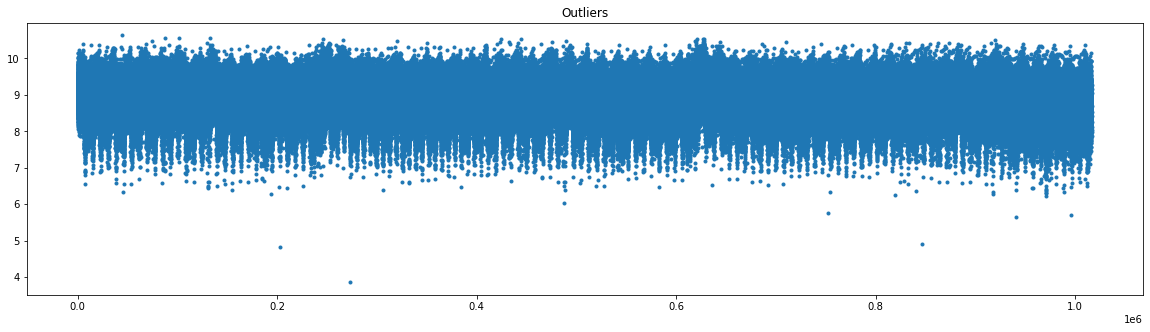

In [83]:
data_prep['sales'].plot(style='.', figsize=(20, 5), title='Outliers');

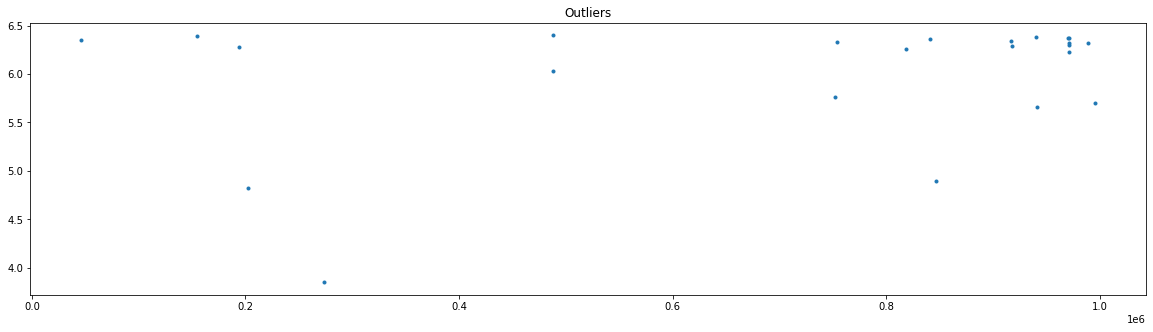

In [84]:
data_prep['sales'].loc[data_prep['sales']< 6.4].plot(style='.', figsize=(20, 5), title='Outliers');

In [85]:
outlier_inf= (data_prep['sales']< 6.4)
data_prep=data_prep[~outlier_inf]

In [86]:
train = data_prep.loc[data_prep['date'] < '2015-06-19']
test = data_prep.loc[data_prep['date'] >= '2015-06-19']

y_train = train[target]
X_train = train[default_features]#default_features, ts_features

y_test = test[target]
X_test = test[default_features]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((802920, 15), (802920,), (41395, 15), (41395,))

## Holdout

In [87]:
def ml_error(y, yhat, model_name=False):
    r2 = r2_score(y, yhat)
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    mpe = np.mean((y-yhat)/y)
    rmpse  = np.sqrt(np.mean((yhat/y-1)**2)) 
    
    return pd.DataFrame( { 'Model' : model_name,
                           'R²': r2,
                           'MAE': mae, 
                           'MAPE': mape,
                           'MPE' : mpe,
                           'RMSE': rmse,
                           'RMPSE': rmpse}, index=[0] )

### Random Forest Regressor

In [14]:
%%time
np.random.seed(7)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)
#rf_results = ml_error( np.expm1(y_test), np.expm1(y_pred), "Random Forest")
#rf_results

rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
rmpse = np.sqrt(np.mean((y_test/y_pred-1) ** 2))
    
print("Random Forest Regressor - Holdout")
print(f"RMSE:{rmse}")
print(f"RMPSE:{rmpse}") 

KeyboardInterrupt: 

### XGBoost Regressor

In [88]:
%%time
np.random.seed(7)

xgb = XGBRegressor(objective='reg:squarederror')
xgb.fit(X_train, y_train)
y_pred=xgb.predict(X_test)

xgb_result = ml_error(np.expm1(y_test), np.expm1( y_pred))
#xgb_result = ml_error(y_test, y_pred)
#xgb_result

rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
rmpse = np.sqrt(np.mean((np.expm1(y_test)/np.expm1(y_pred)-1) ** 2))
    
print("XGBoost - Holdout")
print(f"RMSE:{rmse}")
print(f"RMPSE:{rmpse}") 

XGBoost - Holdout
RMSE:1334.2707452242746
RMPSE:0.18061425783593366
Wall time: 8.86 s


## Hiperparamters Tunning

In [129]:
%%time
#Tunning Parameters: XGBoost Regressor
np.random.seed(7)

params = {
   'n_estimators': [2500],
   'eta': [0.01, 0.03],
   'max_depth': [5],
   #'subsample': [0.1, 0.5],
   #'min_child_weight': [3, 8]
    }

gs = GridSearchCV(xgb, params, cv=2, scoring='neg_mean_squared_error',verbose=100, return_train_score=False)
gs.fit(X_train,y_train)

xgb_tuning_score = gs.best_score_

print(f"\RMSE Score:{gs.best_score_}") 
print(f"\nBest Paramters:\n{gs.best_params_}") 
print(f"\nBest Estimator:\n{gs.best_estimator_}") 

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV 1/2; 1/2] START eta=0.01, max_depth=5, n_estimators=2500....................
[CV 1/2; 1/2] END eta=0.01, max_depth=5, n_estimators=2500;, score=-0.033 total time= 1.6min
[CV 2/2; 1/2] START eta=0.01, max_depth=5, n_estimators=2500....................
[CV 2/2; 1/2] END eta=0.01, max_depth=5, n_estimators=2500;, score=-0.035 total time= 1.7min
[CV 1/2; 2/2] START eta=0.03, max_depth=5, n_estimators=2500....................
[CV 1/2; 2/2] END eta=0.03, max_depth=5, n_estimators=2500;, score=-0.033 total time= 1.6min
[CV 2/2; 2/2] START eta=0.03, max_depth=5, n_estimators=2500....................
[CV 2/2; 2/2] END eta=0.03, max_depth=5, n_estimators=2500;, score=-0.035 total time= 1.6min
\RMSE Score:-0.03421856141051462

Best Paramters:
{'eta': 0.01, 'max_depth': 5, 'n_estimators': 2500}

Best Estimator:
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample

### Tunned Model

In [90]:
np.random.seed(7)

preds = []
scores = []
# max_depth=5, min_child_weight=3, colsample_bytree=0.7
model_xgb_tuned = XGBRegressor( objective='reg:squarederror', n_estimators =2000, max_depth=6)


model_xgb_tuned.fit(X_train, y_train)
ypred_xgb_tunned=model_xgb_tuned.predict(X_test)
preds.append(ypred_xgb_tunned)
score = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(ypred_xgb_tunned)))
scores.append(score)
print("XGBoost Regressor - Cross Validation")
print(f"RMSE:{score}")
#print(f"RMPSE:{rmpse}") 


#gb_result = ml_error( np.expm1( y_test), np.expm1( y_pred))
#xgb_result = ml_error( y_test, y_pred)
#xgb_result

XGBoost Regressor - Cross Validation
RMSE:1048.9044772651807


In [222]:
xgb_tunned_result = ml_error( np.expm1( y_test), np.expm1( y_pred))
#xgb_result = ml_error( y_test, y_pred)
xgb_tunned_result

C:\Users\Alysson\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input contains infinity or a value too large for dtype('float64').

In [17]:
pickle.dump( xgb, open( 'C:\\Users\\Alysson\\Documents\\Projects\\Rossmann-Sales-Forecast\\model\\model_xgb_tunned.pkl', 'wb' ))

## Feature Importance

### Filter Method


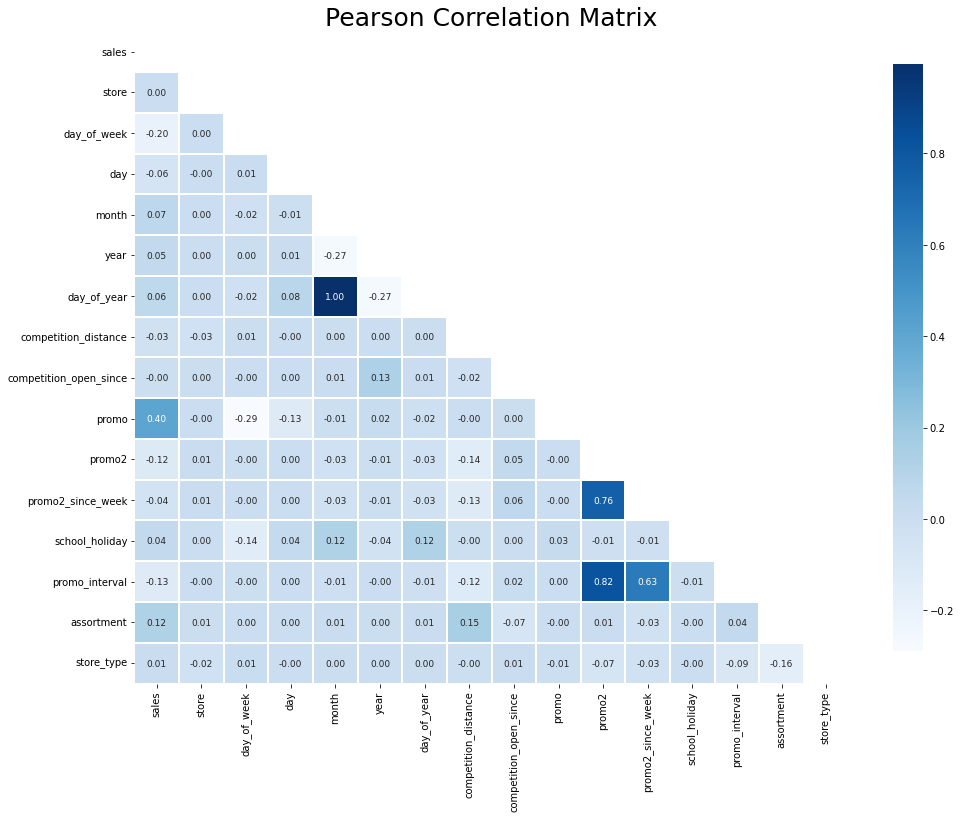

In [20]:
features = ['sales','store',
                     'day_of_week',
                     'day',
                     'month',
                     'year',
                     'day_of_year',
                     'competition_distance',
                     'competition_open_since',
                     'promo',
                     #'is_promo_month',
                     'promo2',
                     #'competition_open_since_month', # Equivalent with competition_open_since
                     #'competition_open_since_year', # Equivalent with competition_open_since
                     'promo2_since_week',
                     'school_holiday', 
                     'promo_interval',
                     #'open',                 
                     'assortment',
                     'store_type']


mask = np.zeros_like(data_prep[features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))

plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(data_prep[features].corr(),linewidths=0.25,fmt=".2f", cmap="Blues", linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});

In [21]:
data_prep[features].corr()['sales'].abs().sort_values(ascending = False)

sales                     1.000000
promo                     0.404815
day_of_week               0.195410
promo_interval            0.125124
assortment                0.121929
promo2                    0.116789
month                     0.069100
day_of_year               0.063560
day                       0.059278
year                      0.046519
school_holiday            0.044196
promo2_since_week         0.043763
competition_distance      0.031295
store_type                0.010596
competition_open_since    0.004806
store                     0.001159
Name: sales, dtype: float64

### Embeeded Method

In [175]:
fi_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

fi_xgb.head(10)

,feature,importance
8,promo,0.274178
9,promo2,0.103462
14,store_type,0.092802
13,assortment,0.091584
12,promo_interval,0.076591
6,competition_distance,0.074454
10,promo2_since_week,0.070541
0,store,0.066054
2,day,0.031857
1,day_of_week,0.026657


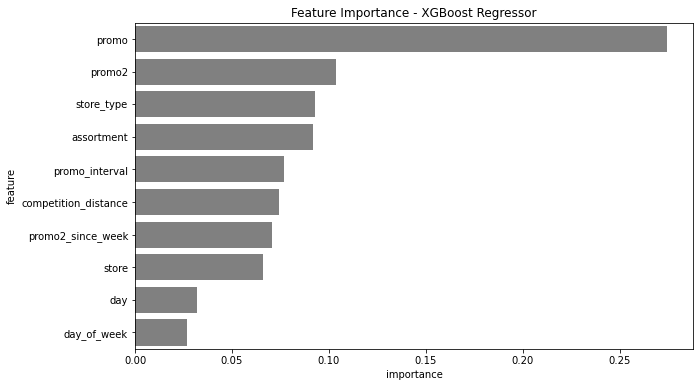

In [193]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance - XGBoost Regressor')
sns.barplot(data=fi_xgb.head(10), x='importance', y='feature', color='gray');
plt.savefig("..//images//xgb_fi.png")
plt.show()

In [35]:
fi_rf = pd.DataFrame({
    'features': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

fi_rf.head(10)

,feature,importance
6,competition_distance,0.244263
0,store,0.188045
8,promo,0.162200
7,competition_open_since,0.085743
1,day_of_week,0.065038
14,store_type,0.052563
5,day_of_year,0.051468
10,promo2_since_week,0.046652
2,day,0.037152
12,promo_interval,0.022482


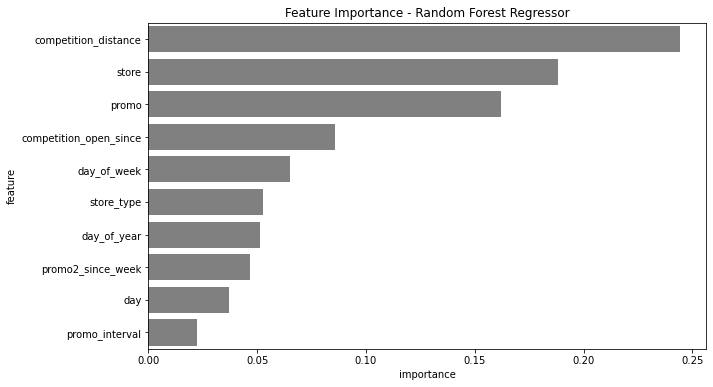

In [36]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance - Random Forest Regressor')
sns.barplot(data=fi_rf.head(10), x='importance', y='features', color='gray');
plt.savefig("..//images//rf_fi.png")
plt.show()

### API Test

In [185]:
df10 = pd.read_csv( '../data/raw/test.csv' )

In [186]:
# merge test dataset + store
df_test = pd.merge( df10, data_store_raw, how='left', on='Store' )

# choose store for prediction
#df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [187]:
df_test=df_test.sample(5)

In [188]:
df_json = json.dumps( df_test.to_dict( orient='records' ) )

In [189]:
df_json

'[{"Store": 426, "DayOfWeek": 2, "Date": "2015-09-08", "Open": 1.0, "Promo": 0, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 250.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 0, "Promo2SinceWeek": NaN, "Promo2SinceYear": NaN, "PromoInterval": NaN}, {"Store": 146, "DayOfWeek": 1, "Date": "2015-08-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "c", "CompetitionDistance": 8050.0, "CompetitionOpenSinceMonth": 10.0, "CompetitionOpenSinceYear": 1961.0, "Promo2": 1, "Promo2SinceWeek": 48.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 955, "DayOfWeek": 4, "Date": "2015-09-03", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "c", "CompetitionDistance": 1690.0, "CompetitionOpenSinceMonth": 7.0, "CompetitionOpenSinceYear": 2009.0, "Promo2": 1, "Promo2SinceWeek": 36.0, "Promo

In [190]:
#url='http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-forecast-01.herokuapp.com/rossmann/predict'
#https://rossmann-forecast-75.herokuapp.com/rossmann/predict/
#url = 'https://winequalitytest123.herokuapp.com/predict'
header = {'Content-type': 'application/json'}
r = requests.post(url=url, data=df_json, headers=header)
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [191]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [192]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 146 will sell R$9928.3369140625 in the next 6 weeks
Store Number 426 will sell R$8520.814453125 in the next 6 weeks
Store Number 605 will sell R$11320.267578125 in the next 6 weeks
Store Number 955 will sell R$10595.6923828125 in the next 6 weeks
Store Number 1056 will sell R$11866.4384765625 in the next 6 weeks


## Results

In [118]:
df9 = test.copy()

In [119]:
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( ypred_xgb_tunned )

In [120]:
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()
#df91['predictions']=round(df91['predictions'],0)
df91

,store,predictions
0,1,162683.828125
1,2,171031.171875
2,3,244456.828125
3,4,341213.031250
4,5,171623.296875
...,...,...
1110,1111,172304.953125
1111,1112,338087.781250
1112,1113,230592.109375
1113,1114,790189.187500


In [123]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#rmpse = np.sqrt(np.mean((np.expm1(y_test)/np.expm1(y_pred)-1) ** 2))


# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [124]:
df92.sort_values( 'MAE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
908,909,245955.031250,238339.331373,253570.731127,7615.699877,0.554151
875,876,222881.718750,218642.382728,227121.054772,4239.336022,0.330479
335,336,376421.281250,372948.082599,379894.479901,3473.198651,0.245932
291,292,106862.078125,103578.711027,110145.445223,3283.367098,0.558523
594,595,421985.250000,418762.105086,425208.394914,3223.144914,0.221848


In [42]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$284,635,264.00"
1,worst_scenario,"R$283,594,855.21"
2,best_scenario,"R$285,675,720.59"


In [144]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = 1 - (df9['predictions'] / df9['sales'])

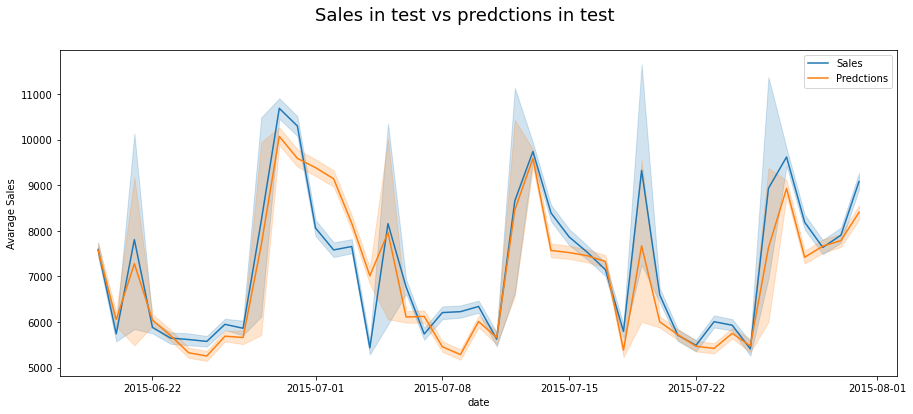

In [151]:
plt.figure(figsize=(15,6))
plt.suptitle('Sales in test vs predctions in test', fontsize=18)
sns.lineplot( x='date', y='sales', data=df9, label='Sales' )
sns.lineplot( x='date', y='predictions', data=df9, label='Predctions')
plt.ylabel("Avarage Sales")
plt.savefig("..//images//results_predction.png")

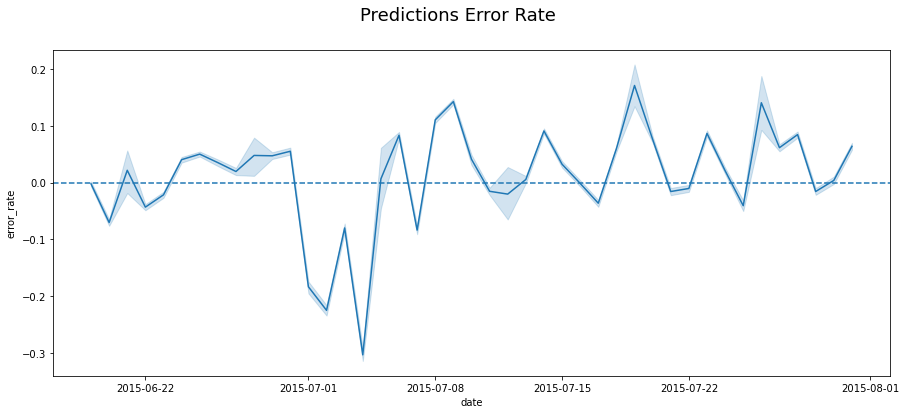

In [147]:
plt.figure(figsize=(15,6))
plt.suptitle('Predictions Error Rate', fontsize=18)
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 0, linestyle='--')
plt.savefig("..//images//results_error_rate.png")

C:\Users\Alysson\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


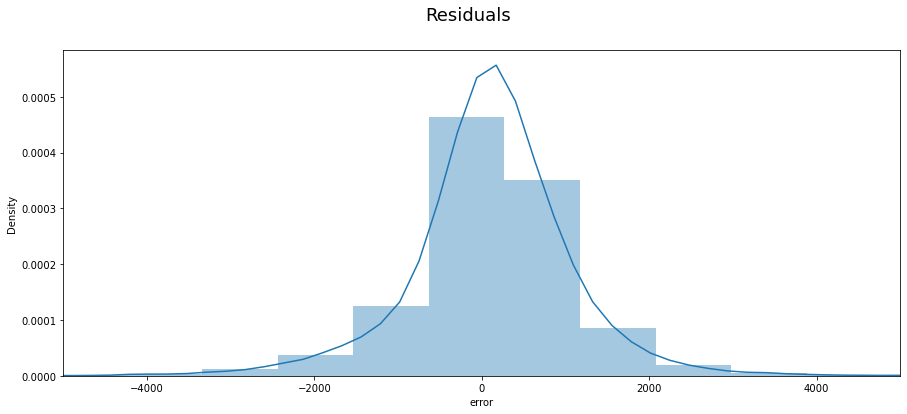

In [148]:
plt.figure(figsize=(15,6))
plt.suptitle('Residuals', fontsize=18)
plt.xlim(-5000, 5000)
sns.distplot(df9['error'])
plt.savefig("..//images//results_residuals.png")

C:\Users\Alysson\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

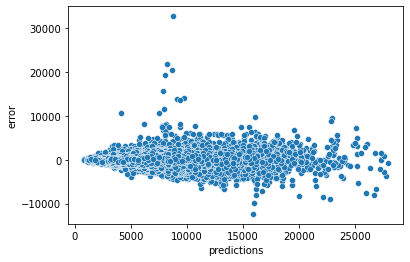

In [149]:
sns.scatterplot( df9['predictions'], df9['error'] )